In [1]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
import chainerx

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from comet_ml import Experiment
def log_cometml(exp, _log_report='LogReport'):
    @training.make_extension(trigger=(1, 'epoch'))
    def _log_exp(trainer):
        log_report = trainer.get_extension(_log_report)
        lastest_log = log_report.log[-1]
        n_epoch = lastest_log.pop('epoch')
        exp.log_metrics(lastest_log, step=n_epoch)
    return _log_exp

In [3]:
# define Model
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [4]:
# define hyperparameters
device = chainer.get_device(0) #CPU = -1, GPU 0~
unit = 784
n_out = 10
batchsize = 100
epoch = 20

In [5]:
# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
model = L.Classifier(MLP(unit, n_out))
model.to_device(device)
device.use()

In [6]:
# Setup an optimizer Adam
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [7]:
# Load DATASET (MNIST)
train, test = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [8]:
# Set up a trainer
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=device)
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                                        'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

In [9]:
#Comet.ml settings
experiment = Experiment(api_key="urqETfWL1zb6MAU0puID4qcxS", project_name="MNIST_DEMO", workspace="sef1224")
experiment.set_name('MLP')
hyper_params = {
    'model_name':'MLP',
    'unit':unit,
    'n_out': n_out,
    'batch_size': batchsize,
    'epoch': epoch,
}
experiment.log_parameters(hyper_params)
trainer.extend(log_cometml(experiment))

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sef1224/mnist-demo/71fb17a2785c4995ac35c18695fa6b29



In [10]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.199006    0.0969505             0.940933       0.9679                    4.36417       
2           0.0737331   0.0744919             0.9775         0.9753                    6.77184       
3           0.0491073   0.0704848             0.983966       0.9781                    9.06342       
4           0.0365379   0.0715403             0.988131       0.9788                    11.7402       
5           0.0280298   0.0750446             0.990799       0.9781                    14.3778       
6           0.0239707   0.0819837             0.992065       0.9793                    17.0652       
7           0.0194489   0.0886457             0.993699       0.9787                    19.6808       
8           0.0173833   0.0893994             0.993965       0.979                     22.6359       
9           0.0169483   0.076358              0.994432       0.9827                 

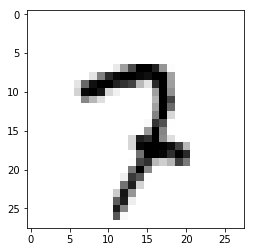

In [11]:
x, y = test[41]
plt.imshow(x.reshape(28,28),cmap='gray_r')

In [12]:
model.to_cpu()
pred = F.softmax(model.predictor(x.reshape(1, 784))).data
print("Prediction: "+str(np.argmax(pred)))
print("Answer: "+str(y))

Prediction: 7
Answer: 7


In [13]:
#chainer.serializers.save_npz("mymodel.npz", model)

In [14]:
#model = L.Classifier(MLP(unit, n_out))
#chainer.serializers.load_npz("mymodel.npz", model)